In [168]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-03-30T13:30:55

CPython 2.7.6
IPython 5.2.2

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [286]:
import tensorflow as tf
import numpy as np
import os
print(tf.__version__)

1.0.0


In [287]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [288]:
csv_file = './../code/data.csv'

In [289]:
def load_csv_data(file_name):
    dataset = []
    labels = []
    if not os.path.exists(file_name):        
        print csv_file, 'is not existing!'
        return dataset, labels
    
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:            
            items = line.strip('\n').split(',')            
            assert(len(items) == 3)
            dataset.append(items[:2])
            labels.append(items[-1:])
    return dataset, labels
            
train_dataset, train_labels = load_csv_data(csv_file)

num_labels = 2
num_input = 2
data_size = len(train_dataset)

train_dataset = np.array(train_dataset)
train_labels = np.array(train_labels)

print(train_dataset.shape)
print(train_labels.shape)

print(train_dataset[:10])
print(train_labels[:10])


(200, 2)
(200, 1)
[['0.3444989038202113' '1.935181339067968']
 ['-0.19248083357568158' '0.9426635874412216']
 ['0.5827218692510598' '-0.8801240556599986']
 ['0.15154953715071828' '-1.0116493917023306']
 ['0.5450826896901235' '-1.7135021017362515']
 ['-0.9353328105768313' '-0.27294270473223603']
 ['0.8281198499789801' '-0.7647471504899532']
 ['-0.5620270118061645' '0.9530543344369632']
 ['0.8105408238147591' '-1.744697043417581']
 ['0.07589885196737622' '-1.9698145754965455']]
[['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['1']
 ['1']
 ['1']
 ['0']
 ['0']]


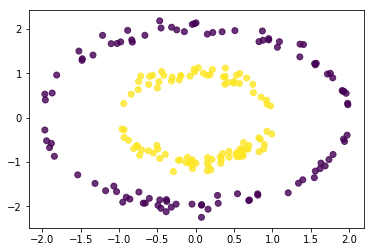

In [290]:
plt.scatter(train_dataset[:,0],train_dataset[:,1],c=train_labels, alpha=0.8)

In [291]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, 2)).astype(np.float32)
    
    #create one-hot matrix
    lables_matrix = np.zeros((data_size, num_labels))
    
    i = 0
    for label in labels:
        hot_index = 0
        tmp = float(label[0])
        if (tmp >0.1):
            hot_index = 1
        lables_matrix[i][hot_index] = 1.0
        i += 1
            
    return dataset, lables_matrix

train_dataset, train_labels = reformat(train_dataset, train_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print(train_labels[:10])


('Training set', (200, 2), (200, 2))
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [292]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [293]:
X = train_dataset

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

print xx.shape, yy.shape

test_dataset = np.c_[xx.ravel(), yy.ravel()]
print test_dataset.shape
#test_dataset = test_dataset.reshape((-1, 2)).astype(np.float32)

testdata_size = test_dataset.shape[0]
print testdata_size

(65, 60) (65, 60)
(3900, 2)
3900


In [294]:
tf.reset_default_graph()

In [295]:
#No hidden layer
batch_size = 100

graph1 = tf.Graph()
with graph1.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_input))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))  
    tf_test_dataset = tf.placeholder(tf.float32, shape=(testdata_size, num_input))
    
    weights = tf.Variable(tf.truncated_normal([num_input, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))   
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.sigmoid(logits)
    test_prediction = tf.nn.sigmoid(tf.matmul(tf_test_dataset, weights) + biases)
    

In [296]:
num_steps = 10000

with tf.Session(graph=graph1) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (data_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_test_dataset : test_dataset}
        _, l, predictions = sess.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if ((step+1) % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step+1, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    feed_dict = {tf_test_dataset : test_dataset}
    test_predict1 = sess.run(test_prediction, feed_dict=feed_dict)
     

Initialized
Minibatch loss at step 1000: 0.751616
Minibatch accuracy: 52.0%
Minibatch loss at step 2000: 0.709616
Minibatch accuracy: 51.0%
Minibatch loss at step 3000: 0.695337
Minibatch accuracy: 52.0%
Minibatch loss at step 4000: 0.691104
Minibatch accuracy: 50.0%
Minibatch loss at step 5000: 0.690003
Minibatch accuracy: 59.0%
Minibatch loss at step 6000: 0.689802
Minibatch accuracy: 60.0%
Minibatch loss at step 7000: 0.689830
Minibatch accuracy: 59.0%
Minibatch loss at step 8000: 0.689895
Minibatch accuracy: 58.0%
Minibatch loss at step 9000: 0.689952
Minibatch accuracy: 59.0%
Minibatch loss at step 10000: 0.689991
Minibatch accuracy: 59.0%


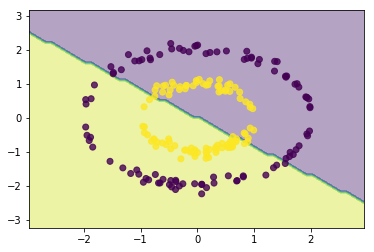

In [297]:
Z = np.argmax(test_predict1, 1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(train_dataset[:,0], train_dataset[:,1],c=np.argmax(train_labels, 1), alpha=0.8)

In [310]:
#With hidden layer
batch_size = 100
num_hidden = 10


tf.reset_default_graph()

graph2 = tf.Graph()
with graph2.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_input))    
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))   
    
    tf_test_dataset = tf.placeholder(tf.float32, shape=(testdata_size, num_input))
    
    weights1 = tf.Variable(tf.truncated_normal([num_input, num_hidden]))
    biases1 = tf.Variable(tf.zeros([num_hidden]))   
    
    logits1 = tf.matmul(tf_train_dataset, weights1) + biases1
    hidden = tf.nn.tanh(logits1)
    
    weights2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels])) 
    
    # Training computation.
    logits2 = tf.matmul(hidden, weights2) + biases2
    loss2 = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits2))
        #tf.losses.sigmoid_cross_entropy(labels=tf_train_labels, logits=logits2))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss2)
    
    # Predictions for the training and test data.
    train_prediction = tf.nn.sigmoid(logits2)
    
    test_logits1 = tf.matmul(tf_test_dataset, weights1) + biases1
    test_logits2 = tf.matmul(tf.nn.tanh(test_logits1), weights2) + biases2
    test_prediction = tf.nn.sigmoid(test_logits2)

In [311]:
num_steps = 10000

with tf.Session(graph=graph2) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (data_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = sess.run(
            [optimizer, loss2, train_prediction], feed_dict=feed_dict)

        if ((step+1) % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step+1, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))

    feed_dict = {tf_test_dataset : test_dataset}
    test_predict2 = sess.run(test_prediction, feed_dict=feed_dict)
  

Initialized
Minibatch loss at step 1000: 0.613009
Minibatch accuracy: 81.0%
Minibatch loss at step 2000: 0.532546
Minibatch accuracy: 81.0%
Minibatch loss at step 3000: 0.457920
Minibatch accuracy: 93.0%
Minibatch loss at step 4000: 0.389466
Minibatch accuracy: 94.0%
Minibatch loss at step 5000: 0.332206
Minibatch accuracy: 96.0%
Minibatch loss at step 6000: 0.285261
Minibatch accuracy: 100.0%
Minibatch loss at step 7000: 0.246864
Minibatch accuracy: 100.0%
Minibatch loss at step 8000: 0.215360
Minibatch accuracy: 100.0%
Minibatch loss at step 9000: 0.189441
Minibatch accuracy: 100.0%
Minibatch loss at step 10000: 0.168034
Minibatch accuracy: 100.0%


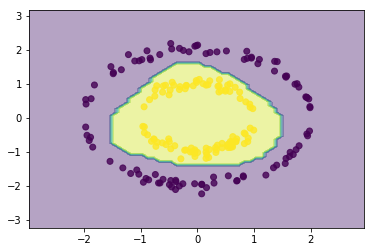

In [313]:
Z = np.argmax(test_predict2, 1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(train_dataset[:,0], train_dataset[:,1],c=np.argmax(train_labels, 1), alpha=0.8)

In [309]:
writer = tf.summary.FileWriter("/root/log", graph=tf.get_default_graph())